In [ ]:
# LSTM

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import math

# ==== 1) Load ====
file_path = r"D:\Vamsi\AirView_Cleaned.csv"
df = pd.read_csv(file_path)
df['local_time'] = pd.to_datetime(df['local_time'])

# ==== 2) One station ====
station_name = df['station_name'].unique()[0]
station_df = df[df['station_name'] == station_name].sort_values('local_time')

# ==== 3) Features & scaling ====
features = ['AT', 'RH', 'PM2_5', 'PM10', 'CO2']
data = station_df[features].values

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# ==== 4) Sequences (past 24h -> next hour) ====
def create_sequences(dataset, seq_length=24):
    X, y = [], []
    for i in range(len(dataset) - seq_length):
        X.append(dataset[i:i+seq_length])
        y.append(dataset[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24
X, y = create_sequences(scaled_data, seq_length)

# Time index aligned with y
time_y = station_df['local_time'].iloc[seq_length:].reset_index(drop=True)

# ==== 5) Train on WHOLE dataset ====
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(len(features))   # multi-output
])
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)


C:\Users\Joshuva\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.fit(X, y, epochs=200, batch_size=32, verbose=1, callbacks=[early_stop])  # whole data, no split

Epoch 1/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 0.0360
Epoch 2/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0104
Epoch 3/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0076
Epoch 4/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0067
Epoch 5/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0061
Epoch 6/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0056
Epoch 7/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0051
Epoch 8/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0047
Epoch 9/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0046
Epoch 10/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0044
Epoch 11/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0041
Epoch 12/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0041
Epoch 13/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0039
Epoch 14/200
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0039
Epoch 15/200
188/188 ━━━━━

In [17]:
# ==== 6) Evaluate only last 30 days (from training data) ====
test_hours = 24 * 30
X_eval = X[-test_hours:]
y_eval = y[-test_hours:]
t_eval = time_y.iloc[-test_hours:]

pred_scaled = model.predict(X_eval, verbose=0)

# Back to original units
pred = scaler.inverse_transform(pred_scaled)
y_true = scaler.inverse_transform(y_eval)

In [18]:
# ==== 7) Metrics ====
print("\n📊 Model Evaluation (Last 30 Days of Training Data):")
for i, col in enumerate(features):
    rmse = math.sqrt(mean_squared_error(y_true[:, i], pred[:, i]))
    mae = mean_absolute_error(y_true[:, i], pred[:, i])
    print(f"{col} → RMSE: {rmse:.2f}, MAE: {mae:.2f}")


📊 Model Evaluation (Last 30 Days of Training Data):
AT → RMSE: 1.49, MAE: 1.26
RH → RMSE: 4.93, MAE: 3.80
PM2_5 → RMSE: 8.05, MAE: 7.15
PM10 → RMSE: 28.53, MAE: 21.01
CO2 → RMSE: 11.30, MAE: 7.24


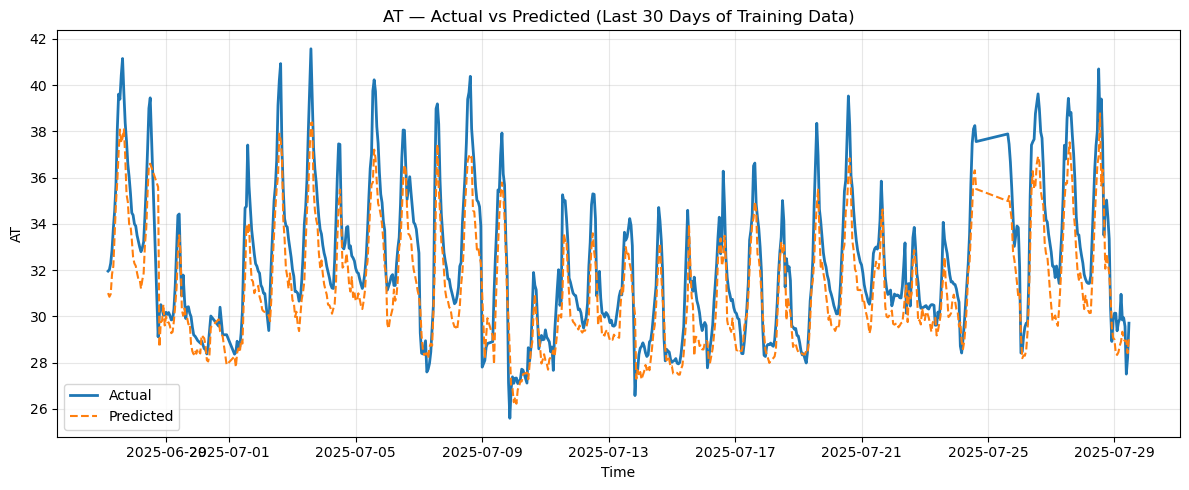

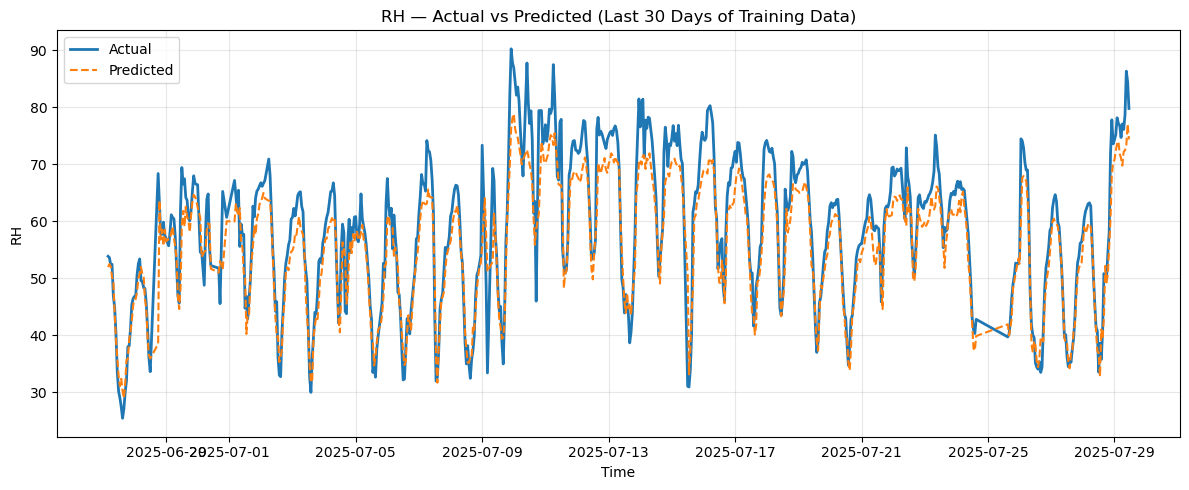

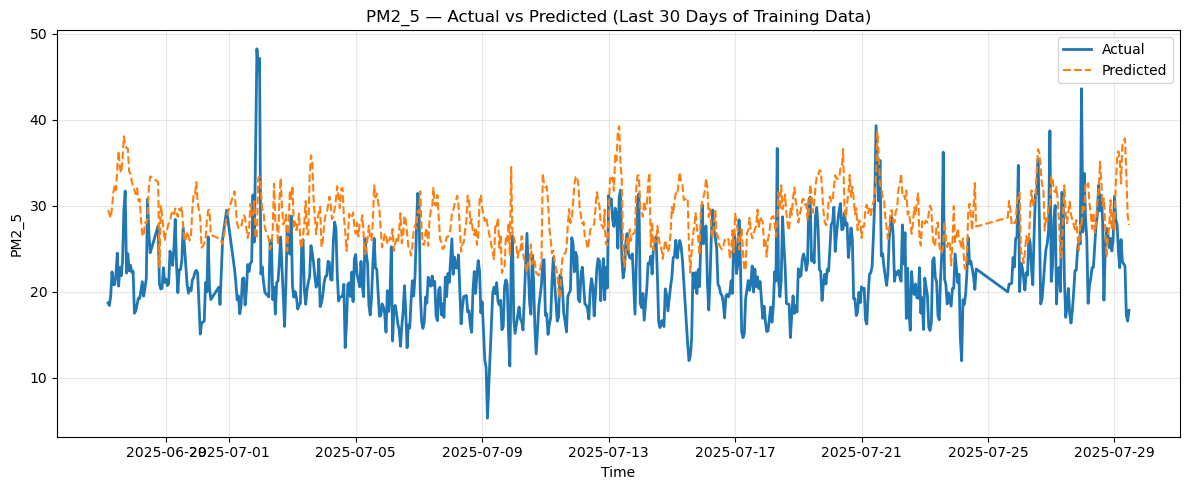

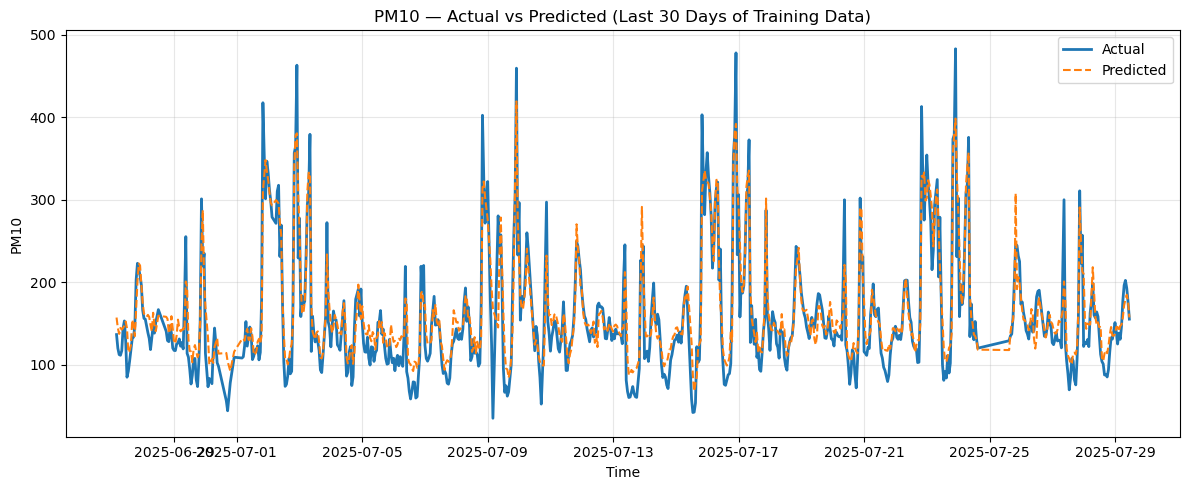

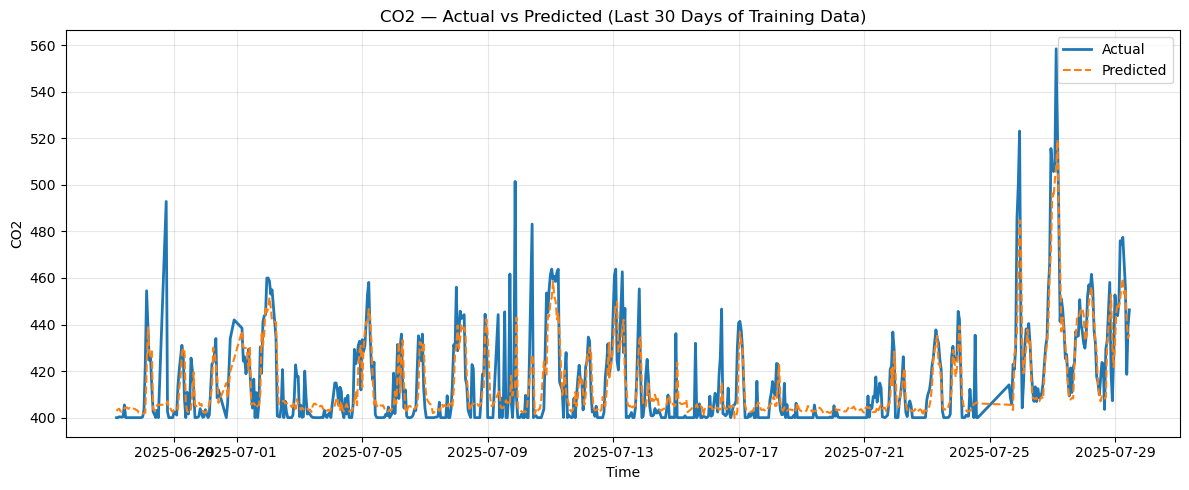

In [19]:
# ==== 8) Plots ====
for i, col in enumerate(features):
    plt.figure(figsize=(12, 5))
    plt.plot(t_eval, y_true[:, i], label='Actual', linewidth=2)
    plt.plot(t_eval, pred[:, i], label='Predicted', linestyle='--')
    plt.title(f'{col} — Actual vs Predicted (Last 30 Days of Training Data)')
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# SARIMAX

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ==== 1. Load cleaned dataset ====
file_path = r"D:\Vamsi\AirView_Cleaned.csv"
df = pd.read_csv(file_path)

# Convert to datetime
df['local_time'] = pd.to_datetime(df['local_time'])

# ==== 2. Select one station ====
station_name = df['station_name'].unique()[0]
station_df = df[df['station_name'] == station_name].sort_values('local_time')

# Remove duplicate timestamps
station_df = station_df.drop_duplicates(subset='local_time')

# ==== 3. Features ====
features = ['AT', 'RH', 'PM2_5', 'PM10', 'CO2']


==== Predicting last 30 days of AT with SARIMA ====


C:\Users\Joshuva\AppData\Local\Temp\ipykernel_8588\4050716250.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = station_df.set_index('local_time')[feature].resample('H').mean().ffill()


MAE: 0.5992
RMSE: 0.9484
MAPE: 1.86%


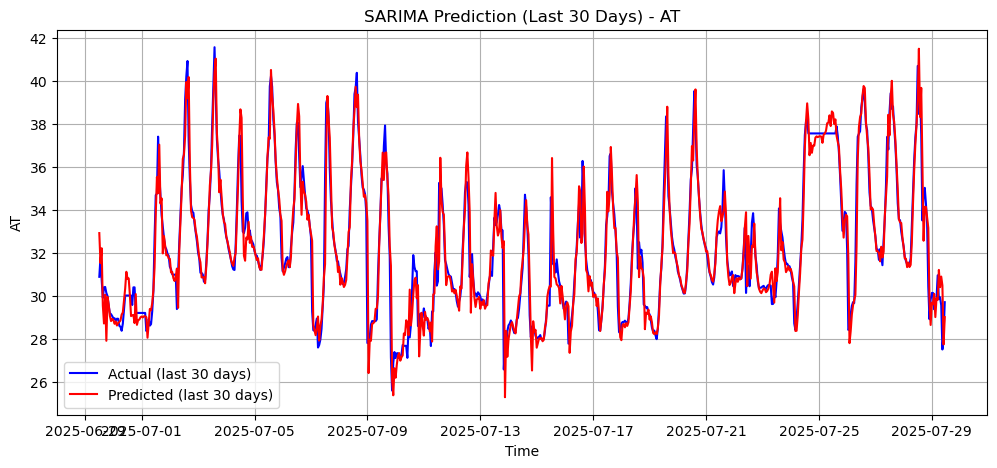


==== Predicting last 30 days of RH with SARIMA ====


C:\Users\Joshuva\AppData\Local\Temp\ipykernel_8588\4050716250.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = station_df.set_index('local_time')[feature].resample('H').mean().ffill()


MAE: 2.9564
RMSE: 4.7647
MAPE: 5.37%


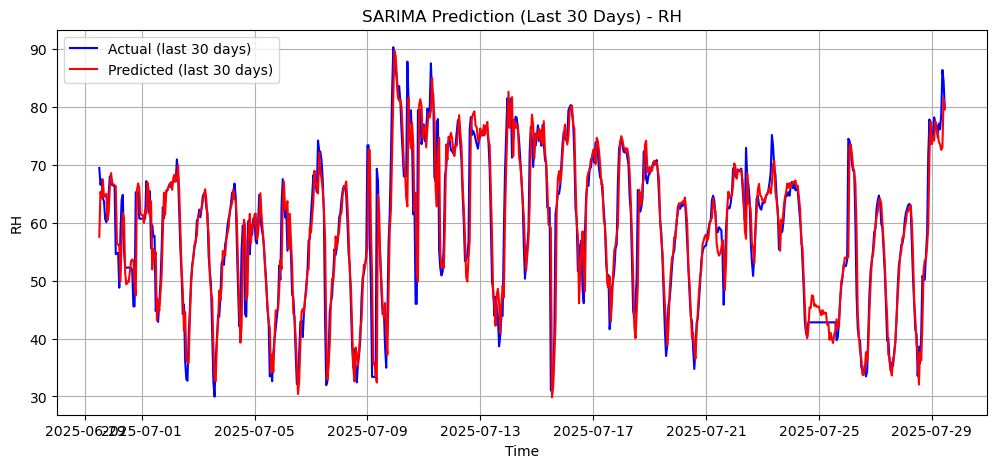


==== Predicting last 30 days of PM2_5 with SARIMA ====


C:\Users\Joshuva\AppData\Local\Temp\ipykernel_8588\4050716250.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = station_df.set_index('local_time')[feature].resample('H').mean().ffill()


MAE: 2.5862
RMSE: 3.6186
MAPE: 12.22%


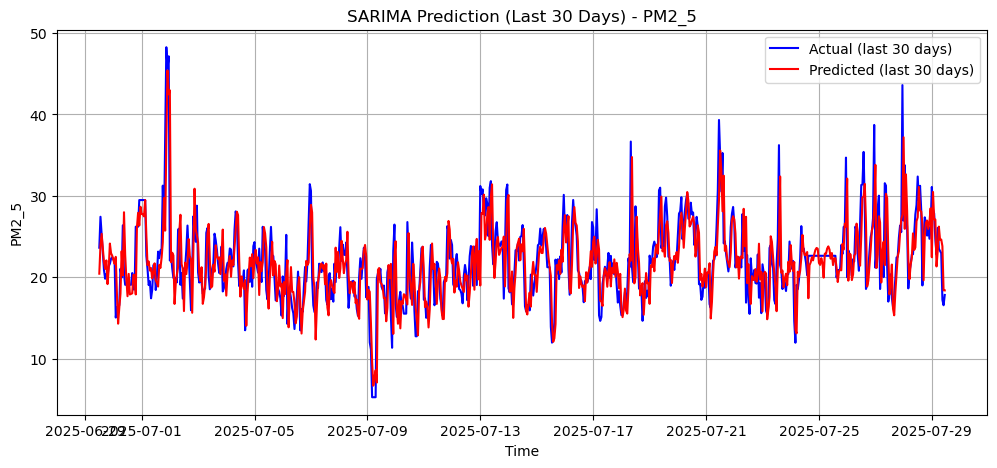


==== Predicting last 30 days of PM10 with SARIMA ====


C:\Users\Joshuva\AppData\Local\Temp\ipykernel_8588\4050716250.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = station_df.set_index('local_time')[feature].resample('H').mean().ffill()


MAE: 28.2616
RMSE: 44.0012
MAPE: 18.85%


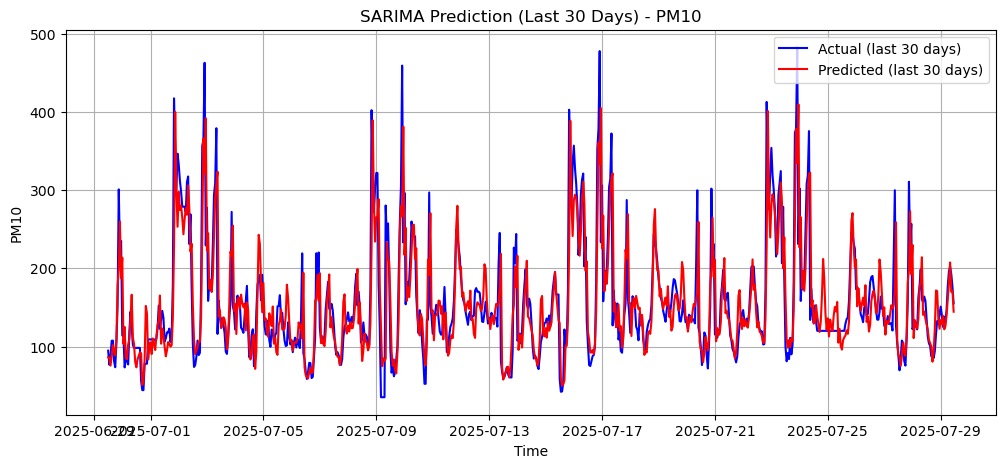


==== Predicting last 30 days of CO2 with SARIMA ====


C:\Users\Joshuva\AppData\Local\Temp\ipykernel_8588\4050716250.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = station_df.set_index('local_time')[feature].resample('H').mean().ffill()


MAE: 7.7468
RMSE: 13.3876
MAPE: 1.82%


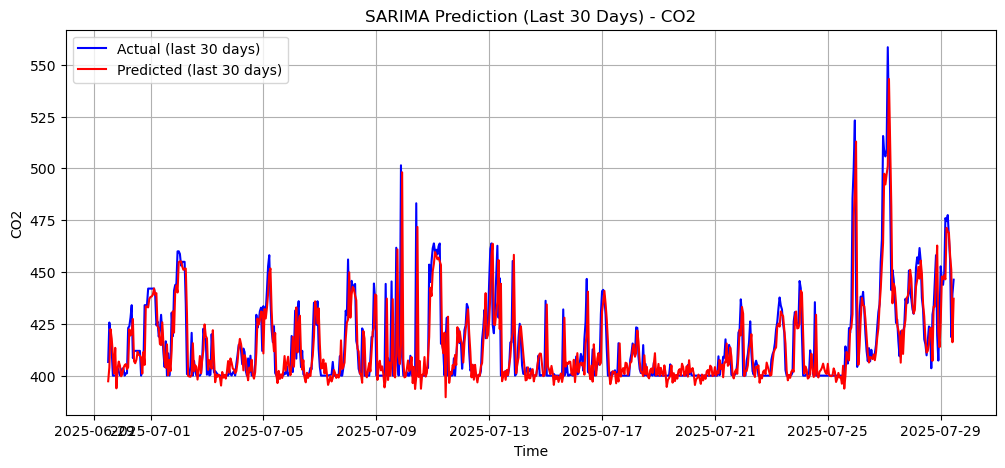

In [32]:
# ==== 4. Loop over each feature for SARIMA prediction ====
for feature in features:
    print(f"\n==== Predicting last 30 days of {feature} with SARIMA ====")

    # Resample to hourly frequency (fill missing)
    ts = station_df.set_index('local_time')[feature].resample('H').mean().ffill()

    # Forecast horizon = last 30 days (30*24 hours)
    forecast_horizon = 30 * 24  
    start_idx = len(ts) - forecast_horizon

    # Fit SARIMA model
    model = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,24))
    model_fit = model.fit(disp=False)

    # Predict the last 30 days
    predictions = model_fit.predict(start=start_idx, end=len(ts)-1)

    # Extract actual last 30 days
    actual_last_30 = ts[-forecast_horizon:]

    # === Metrics ===
    mae = mean_absolute_error(actual_last_30, predictions)
    rmse = np.sqrt(mean_squared_error(actual_last_30, predictions))
    mape = np.mean(np.abs((actual_last_30 - predictions) / actual_last_30)) * 100

    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%")

    # === Plot only last 30 days ===
    plt.figure(figsize=(12, 5))
    plt.plot(actual_last_30.index, actual_last_30, label='Actual (last 30 days)', color='blue')
    plt.plot(predictions.index, predictions, label='Predicted (last 30 days)', color='red')
    plt.title(f"SARIMA Prediction (Last 30 Days) - {feature}")
    plt.xlabel("Time")
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.show()